# Обучение с учителем: качество модели


## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.


## Импорт необходимых библиотек

In [326]:
!pip install shap -q

In [327]:
!pip install phik --q

In [328]:
!pip install scikit-learn==1.1.3 -q

In [329]:
import shap

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import numpy as np

from phik import phik_matrix

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [330]:
RANDOM_STATE=12345
TEST_SIZE=0.25

## Шаг 1. Загрузка данных

In [331]:
market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

Выведем все датафреймы и проверим на соответствие описанию

In [332]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [333]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [334]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [335]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [336]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Промежуточный вывод

Все данные на месте и соответствуют описанию, единственное столбцы Маркет_актив_6_мес следует привести к целому числу. В таблице money разделитель значений — точка с запятой, а разделитель десятичных значений — запятая, мы преобразавали их к нормальному виду

## Шаг 2. Предобработка данных

### Таблица market_file

In [337]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Напишем функцию для вывода основной информации о таблицах

In [338]:
def analyze_dataframe(df_name):
    df = globals()[df_name]

    print("Первые пять строк таблицы:")
    display(df.head(5))
    print()

    print("Информация о таблице:")
    display(df.info())
    print()

    print("Статистическое описание таблицы:")
    display(df.describe())
    print()

    num_missing_values = df.isnull().sum().sum()
    total_cells = df.size
    percentage_missing = (num_missing_values / total_cells) * 100
    print("Количество пропусков: ", num_missing_values)
    print("Процент пропусков: ", percentage_missing, "%")
    print()

    num_duplicates = df.duplicated().sum()
    percentage_duplicates = (num_duplicates / df.shape[0]) * 100
    print("Количество дубликатов: ", num_duplicates)
    print("Процент дубликатов: ", percentage_duplicates, "%")

In [339]:
analyze_dataframe("market_file")

Первые пять строк таблицы:


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_

None


Статистическое описание таблицы:


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000



Количество пропусков:  0
Процент пропусков:  0.0 %

Количество дубликатов:  0
Процент дубликатов:  0.0 %


In [340]:
market_file['Маркет_актив_6_мес'] = market_file['Маркет_актив_6_мес'].astype('int64')

Типы данных соответствуют, пропуски и дубликаты отсутствуют. Сильных аномальных значений также не наблюдается

### Таблица market_money

In [341]:
analyze_dataframe("market_money")

Первые пять строк таблицы:


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None


Статистическое описание таблицы:


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000



Количество пропусков:  0
Процент пропусков:  0.0 %

Количество дубликатов:  0
Процент дубликатов:  0.0 %


Типы данных соответствуют, пропуски и дубликаты отсутствуют. Сильных аномальных значений также не наблюдается

### Таблица market_time

In [342]:
analyze_dataframe("market_time")

Первые пять строк таблицы:


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None


Статистическое описание таблицы:


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000



Количество пропусков:  0
Процент пропусков:  0.0 %

Количество дубликатов:  0
Процент дубликатов:  0.0 %


Типы данных соответствуют, пропуски и дубликаты отсутствуют. Аномальных значений также не наблюдается

### Таблица money

In [343]:
analyze_dataframe("money")

Первые пять строк таблицы:


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None


Статистическое описание таблицы:


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000



Количество пропусков:  0
Процент пропусков:  0.0 %

Количество дубликатов:  0
Процент дубликатов:  0.0 %


Типы данных соответствуют, пропуски и дубликаты отсутствуют. Аномальных значений также не наблюдается

### Промежуточный вывод

Столбцы было принято решение оставить в изначальном виде. Во всех датафреймах отсутствуют пропуски и дублирующиеся строчки. Аномальных значений также не замечено, более подробный анализ будет проведен в следующем шаге

## Шаг 3. Исследовательский анализ данных

### Таблица market_file

In [344]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5,3,1064,0.94,Товары для детей,3,2,3,2


In [345]:
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', \
               'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', \
              'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит' ]

Изучим распределение количественных столбцов

In [346]:
def plot_boxplots(dataframe, num_columns):
    num_plots = len(num_columns)
    num_cols = min(2, num_plots)
    num_rows = (num_plots + 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))

    for i, column in enumerate(num_columns):
        row = i // num_cols
        col = i % num_cols

        ax = axes[row, col] if num_rows > 1 else axes[col]
        dataframe.boxplot(column=column, ax=ax)
        ax.set_title(f"Боксплот для столбца {column}")
        ax.set_xlabel("Столбец")
        ax.set_ylabel("Значение")

    plt.tight_layout()
    plt.show()


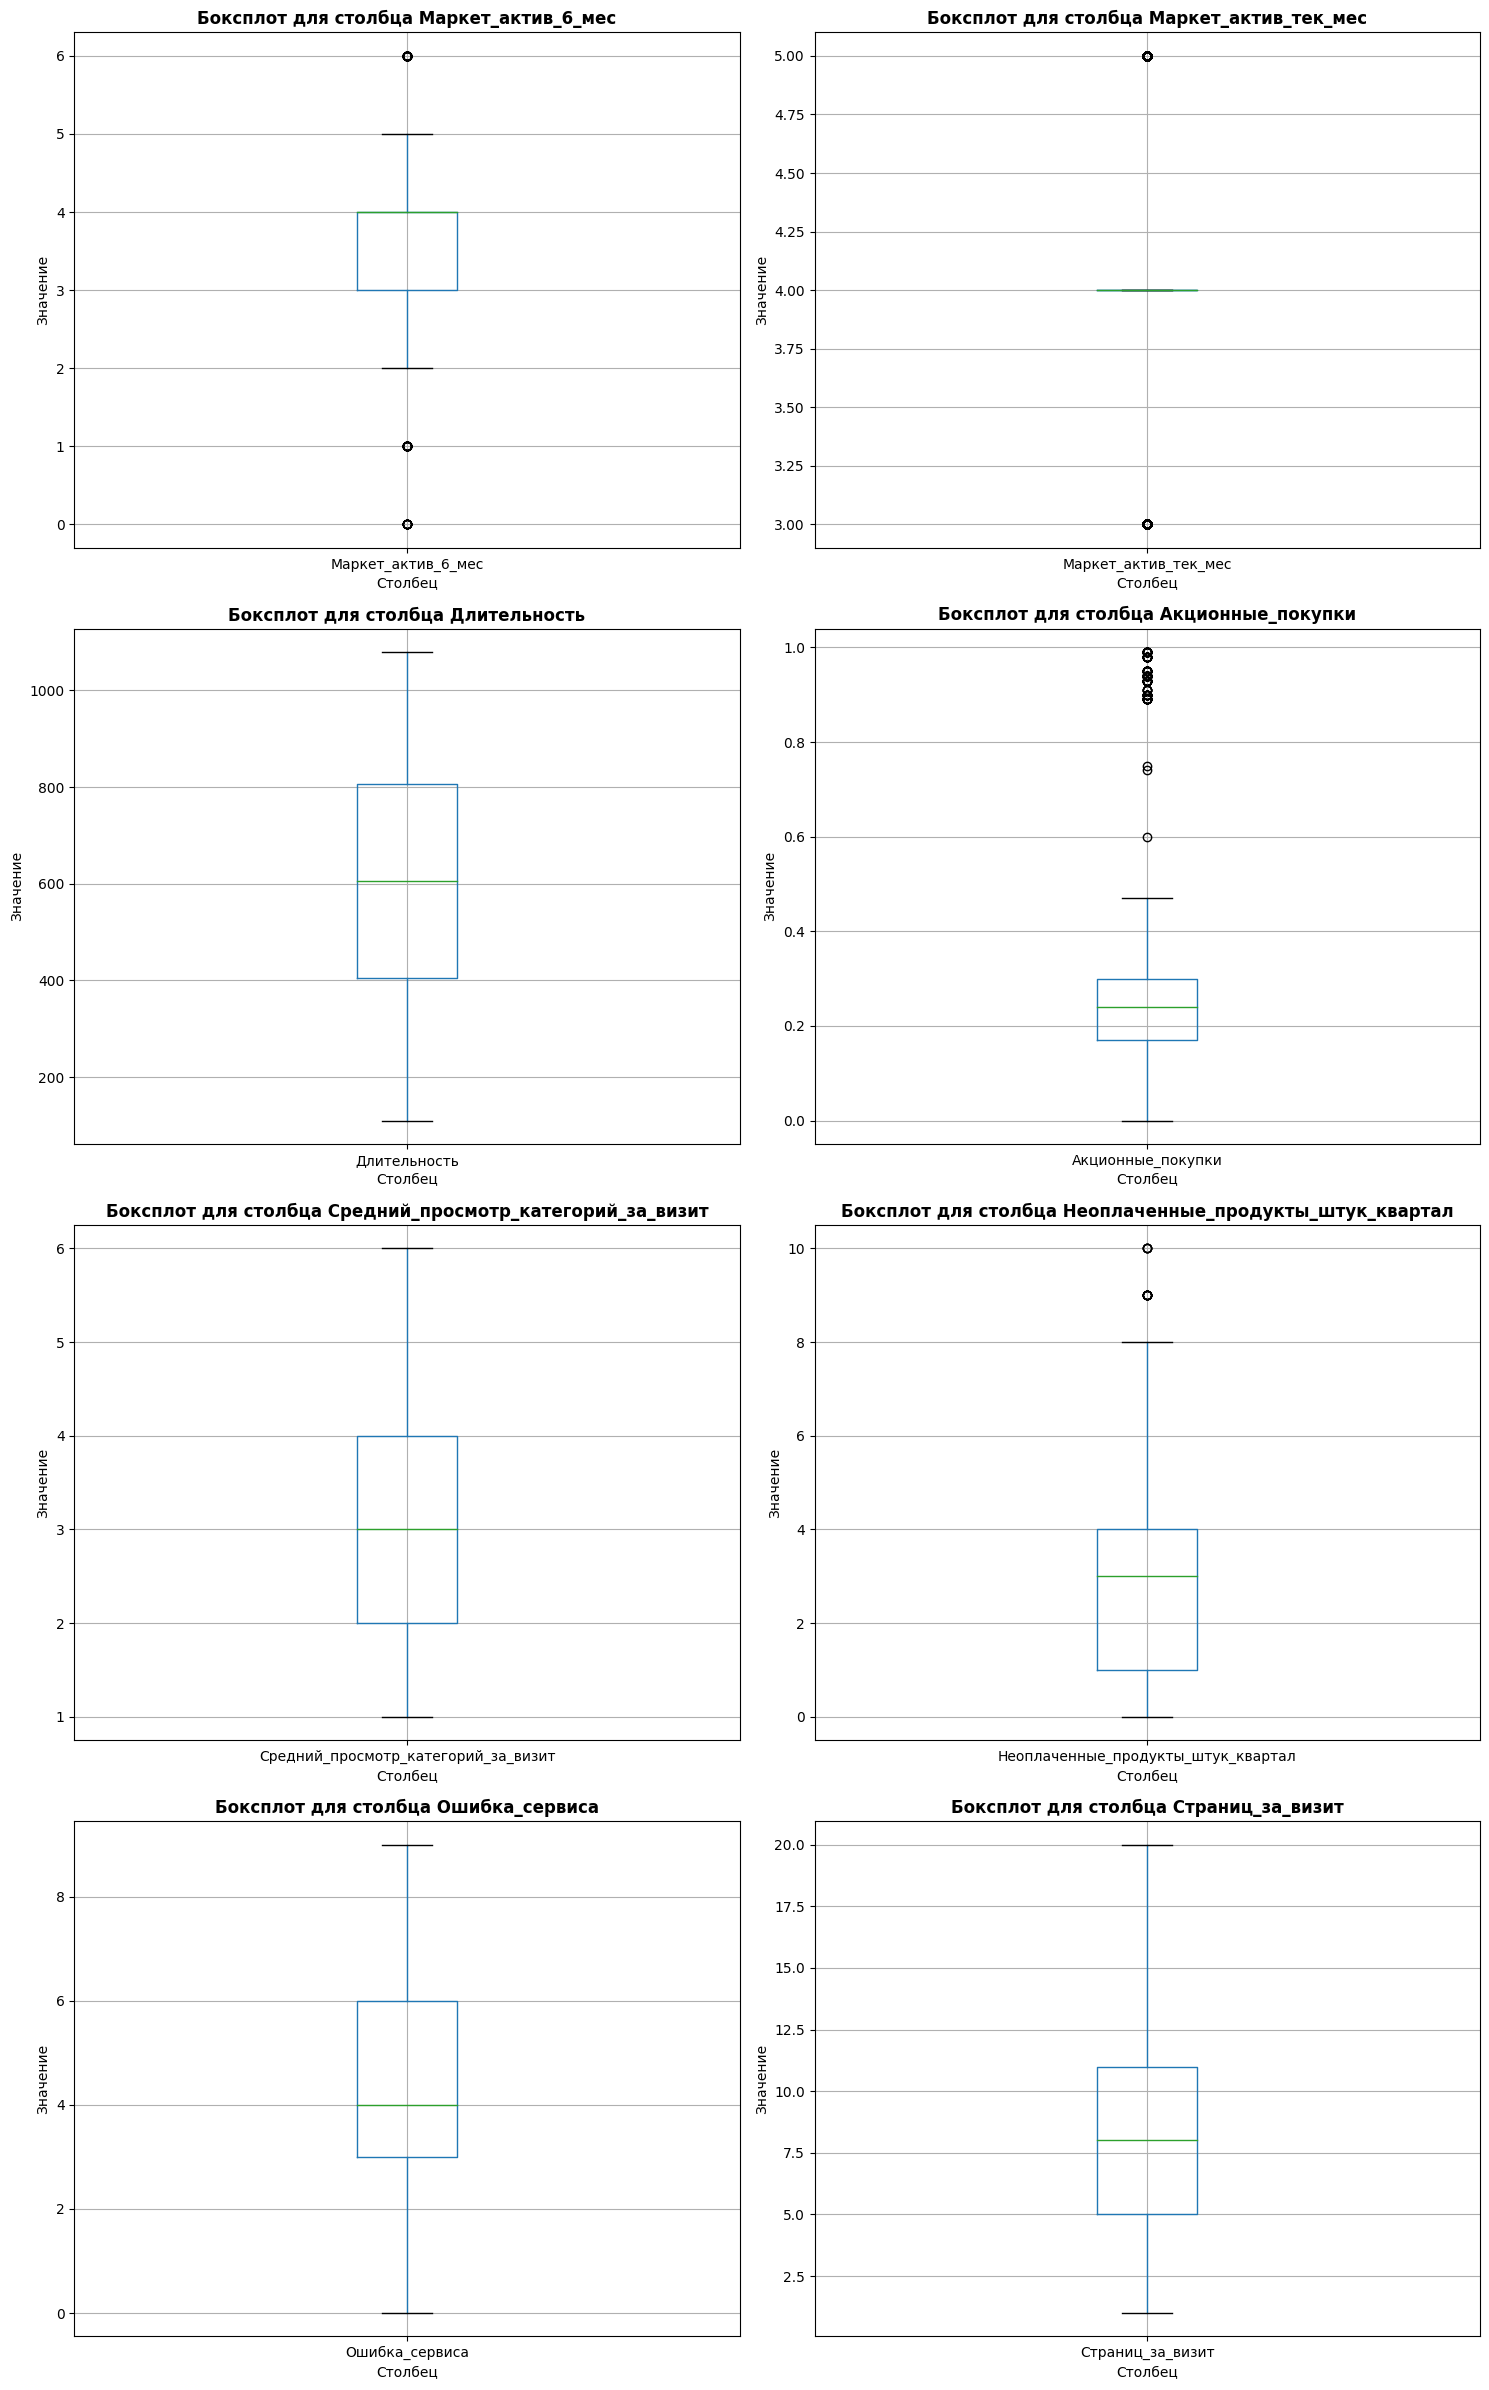

In [347]:
plot_boxplots(market_file, num_columns)

Напишем функцию для отображения гистограмм количественных столбцов

In [348]:
def plot_histograms(dataframe, num_columns):
    num_plots = len(num_columns)
    rows = (num_plots + 1) // 2

    fig = make_subplots(rows=rows, cols=2, subplot_titles=num_columns)

    for i, column in enumerate(num_columns):
        row = (i // 2) + 1
        col = (i % 2) + 1
        fig.add_trace(go.Histogram(x=dataframe[column], nbinsx=20), row=row, col=col)

        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray', row=row, col=col)
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray', row=row, col=col)

        fig.update_xaxes(title_text=column, row=row, col=col)
        fig.update_yaxes(title_text='Количество', row=row, col=col)

    fig.update_layout(showlegend=False, height=400*rows, width=900, title_text="Гистограммы")
    fig.show()

In [349]:
def plot_histograms_one(dataframe, num_columns):
    num_plots = len(num_columns)
    rows = (num_plots + 1) // 2

    colors = ['green', 'orange']  # Updated colors

    fig = make_subplots(rows=rows, cols=2, subplot_titles=num_columns)

    for i, column in enumerate(num_columns):
        row = (i // 2) + 1
        col = (i % 2) + 1
        fig.add_trace(go.Histogram(x=dataframe[dataframe["Покупательская активность"] == "Прежний уровень"][column],
                                   nbinsx=20,
                                   name="Прежний уровень",
                                   marker=dict(color=colors[0])), row=row, col=col)
        fig.add_trace(go.Histogram(x=dataframe[dataframe["Покупательская активность"] == "Снизилась"][column],
                                   nbinsx=20,
                                   name="Снизилась",
                                   marker=dict(color=colors[1])), row=row, col=col)

        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray', row=row, col=col)
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray', row=row, col=col)

        fig.update_xaxes(title_text=column, row=row, col=col)
        fig.update_yaxes(title_text='Count', row=row, col=col)

    # Create a single legend
    fig.update_layout(showlegend=True,
                      height=400*rows, width=1000, title_text="Histograms", legend=dict(traceorder='normal'))

    fig.show()

In [350]:
plot_histograms_one(market_file, num_columns)

In [351]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5,3,1064,0.94,Товары для детей,3,2,3,2


In [352]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,3.796154,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.041473,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.000000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.000000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.000000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.000000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.000000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Большинство столбцов имеют нормально распределение.

- 'Маркет_актив_6_мес'. Зачастую на покупателя приходится примерно 4 маркетинговых активности за 6 месяцев. Всего может быть от 0 до 6.


- 'Маркет_актив_тек_мес'. Чаще всего за месяц на покупателя приходится 4 маркетинговых активности. Реже - 3 или 5. Интересно, что среднее значение такое же, как и за 6 месяцев.


- 'Длительность' - в среднем у пользователей прошло примерно 600 дней с момента регистрации, что равняется 20 месяцам. В целом значение варьируется от 110 до 1000 и распределено довольно равномерно.

- 'Акционные_покупки' - большинство пользователей не совершали покупки по акции.

- 'Средний_просмотр_категорий_за_визит' - чаще всего просматривают 3 категории за визит.

- 'Неоплаченные_продукты_штук_квартал' - обычно покупатели не оплачивают 3 добавленых в корзину товара за 3 месяца.

- 'Ошибка_сервиса' - на сервисе довольно часто происходят сбои - на одного пользователя приходится от 0 до 9 сбоев. Среднее значение - 4 сбоя.

- 'Страниц_за_визит' - чаще всего за один визит покупатель открывает 8 страниц.

Изучим категориальные признаки

In [353]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5,3,1064,0.94,Товары для детей,3,2,3,2


In [354]:
cat_columns = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']

In [355]:
def print_unique_values(columns, data):
    for column in columns:
        unique_values = set(data[column])
        display(f"Уникальные значения в столбце '{column}': {unique_values}")

In [356]:
print_unique_values(cat_columns, market_file)

"Уникальные значения в столбце 'Покупательская активность': {'Снизилась', 'Прежний уровень'}"

"Уникальные значения в столбце 'Тип сервиса': {'премиум', 'стандартт', 'стандарт'}"

"Уникальные значения в столбце 'Разрешить сообщать': {'нет', 'да'}"

"Уникальные значения в столбце 'Популярная_категория': {'Мелкая бытовая техника и электроника', 'Кухонная посуда', 'Техника для красоты и здоровья', 'Косметика и аксесуары', 'Домашний текстиль', 'Товары для детей'}"

В столбце 'Тип сервиса' присутствует опечатка, исправим ее

In [357]:
market_file['Тип сервиса'].value_counts()

Тип сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

In [358]:
market_file.loc[market_file['Тип сервиса'] == 'стандартт', 'Тип сервиса'] = 'стандарт'

In [359]:
market_file['Тип сервиса'].value_counts()

Тип сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

In [360]:
def create_pie_charts(data, columns):
    colors = ['green', 'orange']  # Updated colors

    for column in columns:
        counts = data[column].value_counts()

        df = pd.DataFrame({column: counts.index, 'count': counts.values})

        fig = px.pie(df, values='count', names=column, title=f'Круговая диаграмма для {column}', color_discrete_sequence=colors)
        fig.show()


In [361]:
create_pie_charts(market_file, cat_columns)

Всего магазин продает 6 категорий товара:
- 'Техника для красоты и здоровья',
- 'Кухонная посуда',
- 'Косметика и аксесуары',
- 'Мелкая бытовая техника и электроника',
- 'Домашний текстиль',
- 'Товары для детей'

Они представлены примерно равномерно, однако больше всего представлена категория товаров для детей и домашнего текстиля. Меньше всего приходится на кухонную посуду.

Рассматривая пользователей, можно отметить, что активность 60% процентов находиться на прежнем уровне, более 70% пользователей пользуется стандартным уровнем сервиса и согласны на получение дополнительных предложений о товаре.

В нашем целевом признаке наблюдается дисбаланс, поэтому будем использовать метрику roc_auc

### Таблица market_money

In [362]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [363]:
num_col = ['Выручка']
cat_col = ['Период']

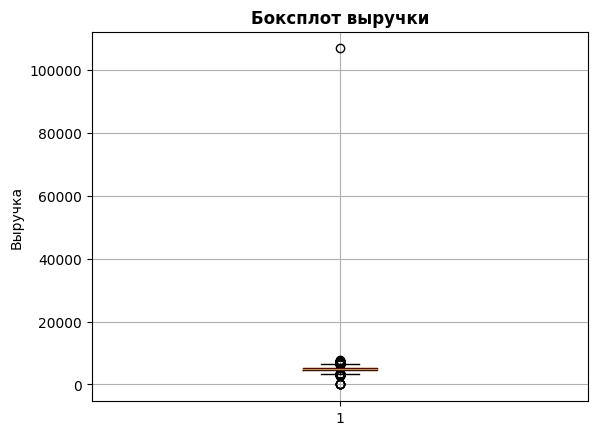

In [364]:
plt.boxplot(market_money['Выручка'])

plt.title('Боксплот выручки')
plt.ylabel('Выручка')

plt.show()

In [365]:
market_money.groupby('Период')['Выручка'].sum()

Период
предыдущий_месяц       6417996.5
препредыдущий_месяц    6272769.0
текущий_месяц          6909449.1
Name: Выручка, dtype: float64

In [366]:
fig = go.Figure()


fig.add_trace(go.Bar(
    x=market_money['Период'],
    y=market_money['Выручка'],
    marker_color='steelblue',
    name='Выручка'
))


fig.update_layout(
    xaxis_title='Период',
    yaxis_title='Выручка',
    title='Столбчатая диаграмма выручки по периодам'
)


fig.show()

In [367]:
plot_histograms(market_money, num_col)

In [368]:
fig = px.histogram(market_time, x='минуут', nbins=10, facet_col='Период', facet_col_wrap=3)

fig.update_layout(
    title='Распределение минут по периодам',
    xaxis=dict(title='Минуты'),
    yaxis=dict(title='Частота')
)

fig.show()

Распредление минут по периодам не отличается

Одно аномальное значение все же присутствует, удалим его и построим графики заново

In [369]:
market_money.drop(market_money[market_money['Выручка'] > 20000].index, inplace=True)

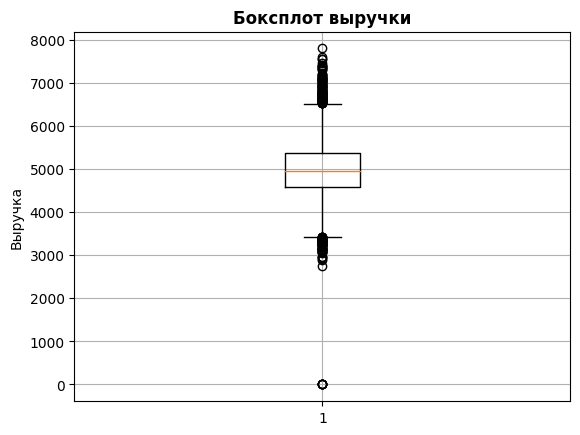

In [370]:
plt.boxplot(market_money['Выручка'])

plt.title('Боксплот выручки')
plt.ylabel('Выручка')

plt.show()

In [371]:
plot_histograms(market_money, num_col)

In [372]:
count_zero_revenue = len(market_money[market_money['Выручка'] == 0])
zero_revenue_rows = market_money[market_money['Выручка'] == 0]
print("Количество строк с нулевой выручкой:", count_zero_revenue)
print("Строки с нулевой выручкой:")
display(zero_revenue_rows)

Количество строк с нулевой выручкой: 6
Строки с нулевой выручкой:


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


У нас 3 клиента, которые не покупали что-либо в эти три месяца. Удалим такие строчки, ведь нам нужны только те пользователи, оторые совершали покупки

In [373]:
ids_to_remove = zero_revenue_rows['id'].unique()

In [374]:
market_money = market_money[~market_money['id'].isin(ids_to_remove)]

In [375]:
plot_histograms(market_money, num_col)

Также рассмотрим выручку по периодам

In [376]:
fig = px.histogram(market_money, x='Выручка', nbins=10, facet_col='Период', facet_col_wrap=3)

fig.update_layout(
    title='Распределение выручки по периодам',
    xaxis=dict(title='Выручка'),
    yaxis=dict(title='Частота')
)

fig.show()

Самые высокие значения выручки в предпредыдущем месяце. В текущем и предыдущем месяцах распределение пости одинаковое

In [377]:
print_unique_values(cat_col, market_money)

"Уникальные значения в столбце 'Период': {'препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц'}"

In [378]:
create_pie_charts(market_money, cat_col)

Периоды представлены равномерно

### Таблица market_time

In [379]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [380]:
num_col_1 = ['минут']
cat_col_1 = ['Период']

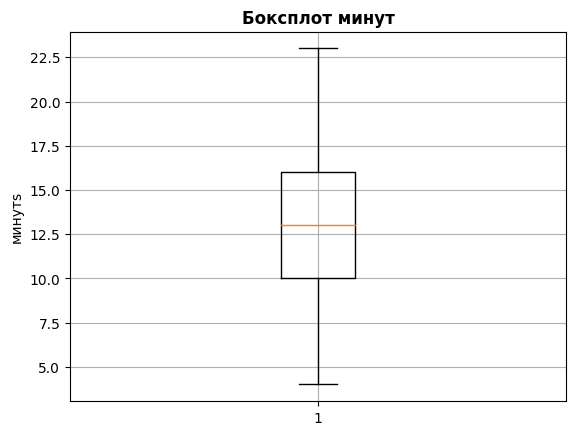

In [381]:
plt.boxplot(market_time['минут'])

plt.title('Боксплот минут')
plt.ylabel('минутs')

plt.show()

In [382]:
plot_histograms(market_time, num_col_1)

Минуты распределены нормально, чаще всего на сайте проводят около 10-15 минут

In [383]:
print_unique_values(cat_col_1, market_time)

"Уникальные значения в столбце 'Период': {'предыдцщий_месяц', 'текущий_месяц'}"

In [384]:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [385]:
create_pie_charts(market_time, cat_col_1)

Периоды распределены равномерно

## Шаг 4. Объединение таблиц

Сначала создадим отдельные столбцы для каждого из периодов

In [386]:
time_pivot = market_time.pivot_table(index=['id'],columns=['Период'],values=['минут'])
time_pivot.columns = ['минуты_предыдущий_месяц','минуты_текущий_месяц']
time_pivot = time_pivot.reset_index()
time_pivot.head()

,id,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [387]:
money_pivot = market_money.pivot_table(index=['id'],columns=['Период'],values=['Выручка'])
money_pivot.columns = ['выручка_предыдущий_месяц','выручка_препредыдущий_месяц','выручка_текущий_месяц']
money_pivot = money_pivot.reset_index()
money_pivot.head()

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [388]:
money_pivot.isna().sum()

id                             0
выручка_предыдущий_месяц       0
выручка_препредыдущий_месяц    0
выручка_текущий_месяц          1
dtype: int64

В ходе создания сводной таблице у нас появился один пропуск, заполним его медианным значением по текущему месяцу

In [389]:
median_revenue = money_pivot['выручка_текущий_месяц'].median()
money_pivot['выручка_текущий_месяц'].fillna(median_revenue, inplace=True)

Объединим полученные таблицы

In [390]:
market_file.reset_index(inplace=True,drop=True)
time_pivot.reset_index(inplace=True,drop=True)
money_pivot.reset_index(inplace=True,drop=True)

In [391]:
df = market_file.merge(time_pivot, on='id',how='inner').merge(money_pivot, on='id', how='inner')
df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,Снизилась,премиум,да,4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5


In [392]:
analyze_dataframe("df")

Первые пять строк таблицы:


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,Снизилась,премиум,да,4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   int64  
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_

None


Статистическое описание таблицы:


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,215998.986893,3.797224,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584,13.469545,13.211257,4948.339630,4836.367772,5238.051234
std,374.578554,1.042192,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061,3.936323,4.220222,701.228571,333.438742,833.998336
min,215349.000000,0.000000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,2890.000000,4098.000000,2758.700000
25%,215675.000000,3.000000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000,11.000000,10.000000,4498.500000,4585.000000,4706.600000
50%,215999.000000,4.000000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000,13.000000,13.000000,5005.500000,4812.000000,5179.950000
75%,216323.000000,4.000000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000,17.000000,16.000000,5409.000000,5055.000000,5758.600000
max,216647.000000,6.000000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,23.000000,23.000000,6869.500000,5663.000000,7799.400000



Количество пропусков:  0
Процент пропусков:  0.0 %

Количество дубликатов:  0
Процент дубликатов:  0.0 %


Данные успешно объединены

## Шаг 5. Корреляционный анализ

In [393]:
corr_matrix = df.phik_matrix()

corr_matrix

interval columns not set, guessing: ['id', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,1.000000,0.984640,0.119882,0.000000,0.339411,0.000000,0.049392,0.414285,0.170373,0.354031,0.417626,0.203942,0.607982,0.564821,0.472584,0.239152,0.419776,0.171698
Покупательская активность,0.984640,1.000000,0.132247,0.000000,0.366809,0.000000,0.101767,0.506991,0.298036,0.539221,0.504845,0.223697,0.748769,0.685078,0.575662,0.227280,0.495174,0.195470
Тип сервиса,0.119882,0.132247,1.000000,0.286278,0.069051,0.044796,0.401158,0.033339,0.066285,0.186635,0.120842,0.076182,0.100832,0.131084,0.000000,0.000000,0.068507,0.123698
Разрешить сообщать,0.000000,0.000000,0.286278,1.000000,0.007792,0.051971,0.253956,0.017252,0.071769,0.069322,0.195442,0.020464,0.041128,0.042350,0.000000,0.079830,0.000000,0.062923
Маркет_актив_6_мес,0.339411,0.366809,0.069051,0.007792,1.000000,0.073702,0.000000,0.274668,0.091560,0.157920,0.202012,0.103439,0.272194,0.248700,0.198932,0.113142,0.200733,0.023964
Маркет_актив_тек_мес,0.000000,0.000000,0.044796,0.051971,0.073702,1.000000,0.174385,0.000000,0.136175,0.246726,0.143827,0.116310,0.000000,0.106879,0.062485,0.054683,0.000000,0.000000
Длительность,0.049392,0.101767,0.401158,0.253956,0.000000,0.174385,1.000000,0.000000,0.000000,0.187774,0.191923,0.174467,0.122727,0.024075,0.100502,0.125303,0.114058,0.147580
Акционные_покупки,0.414285,0.506991,0.033339,0.017252,0.274668,0.000000,0.000000,1.000000,0.122840,0.199417,0.237583,0.000000,0.310741,0.262189,0.250014,0.065412,0.225681,0.069613
Популярная_категория,0.170373,0.298036,0.066285,0.071769,0.091560,0.136175,0.000000,0.122840,1.000000,0.225622,0.248558,0.000000,0.160623,0.195219,0.089923,0.250974,0.045814,0.237957
Средний_просмотр_категорий_за_визит,0.354031,0.539221,0.186635,0.069322,0.157920,0.246726,0.187774,0.199417,0.225622,1.000000,0.325688,0.069908,0.262610,0.159393,0.182708,0.100332,0.176770,0.092720


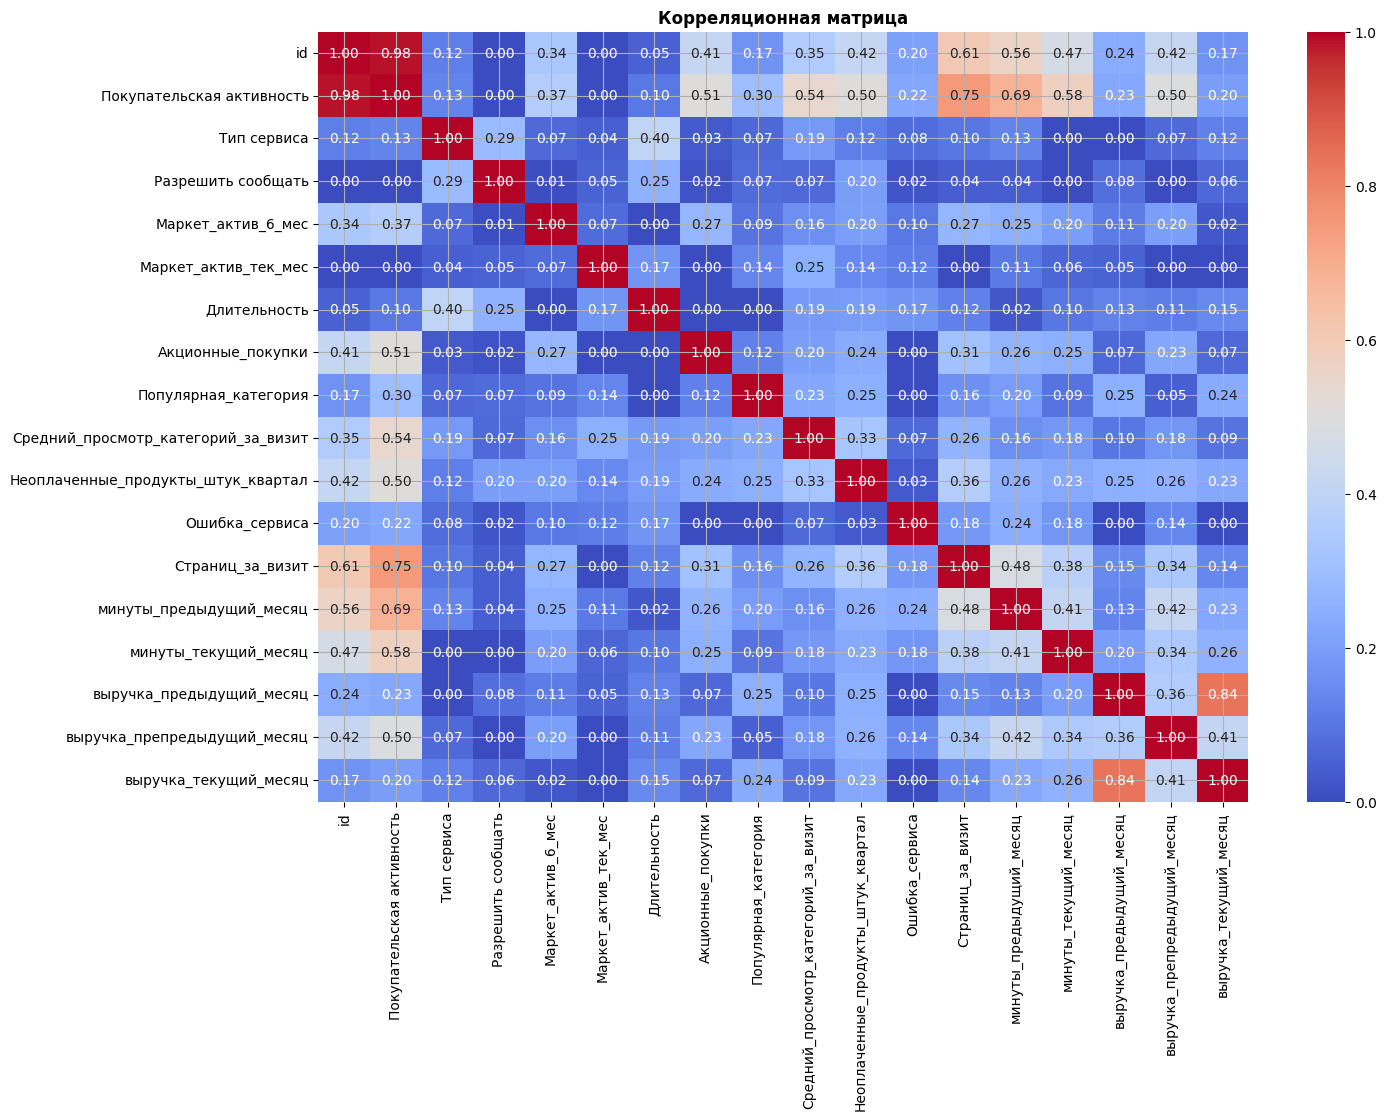

In [394]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

Сильная корреляция наблюдается у id и покупательской активности. id мы можем удалить, так как в любом случае не будем использовать этот столбец при обучении. В остальном все признаки коррелируют в предлеах нормы. Высокая корреляция у выручки за предыдущий месяц и выручки в текущий месяц, но она меньше 0.9, поэтому мы можем ее оставить


In [395]:
df_full_corr = df.copy()

In [396]:
df_full_corr = df_full_corr.drop('id', axis=1)

In [397]:
df_full_corr.phik_matrix()

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']


,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
Покупательская активность,1.000000,0.132247,0.000000,0.366809,0.000000,0.101767,0.506991,0.298036,0.539221,0.504845,0.223697,0.748769,0.685078,0.575662,0.227280,0.495174,0.195470
Тип сервиса,0.132247,1.000000,0.286278,0.069051,0.044796,0.401158,0.033339,0.066285,0.186635,0.120842,0.076182,0.100832,0.131084,0.000000,0.000000,0.068507,0.123698
Разрешить сообщать,0.000000,0.286278,1.000000,0.007792,0.051971,0.253956,0.017252,0.071769,0.069322,0.195442,0.020464,0.041128,0.042350,0.000000,0.079830,0.000000,0.062923
Маркет_актив_6_мес,0.366809,0.069051,0.007792,1.000000,0.073702,0.000000,0.274668,0.091560,0.157920,0.202012,0.103439,0.272194,0.248700,0.198932,0.113142,0.200733,0.023964
Маркет_актив_тек_мес,0.000000,0.044796,0.051971,0.073702,1.000000,0.174385,0.000000,0.136175,0.246726,0.143827,0.116310,0.000000,0.106879,0.062485,0.054683,0.000000,0.000000
Длительность,0.101767,0.401158,0.253956,0.000000,0.174385,1.000000,0.000000,0.000000,0.187774,0.191923,0.174467,0.122727,0.024075,0.100502,0.125303,0.114058,0.147580
Акционные_покупки,0.506991,0.033339,0.017252,0.274668,0.000000,0.000000,1.000000,0.122840,0.199417,0.237583,0.000000,0.310741,0.262189,0.250014,0.065412,0.225681,0.069613
Популярная_категория,0.298036,0.066285,0.071769,0.091560,0.136175,0.000000,0.122840,1.000000,0.225622,0.248558,0.000000,0.160623,0.195219,0.089923,0.250974,0.045814,0.237957
Средний_просмотр_категорий_за_визит,0.539221,0.186635,0.069322,0.157920,0.246726,0.187774,0.199417,0.225622,1.000000,0.325688,0.069908,0.262610,0.159393,0.182708,0.100332,0.176770,0.092720
Неоплаченные_продукты_штук_квартал,0.504845,0.120842,0.195442,0.202012,0.143827,0.191923,0.237583,0.248558,0.325688,1.000000,0.033392,0.363879,0.255982,0.232121,0.249471,0.261530,0.230430


In [398]:
df_full_corr.phik_matrix().iloc[:,1]

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']


Покупательская активность              0.132247
Тип сервиса                            1.000000
Разрешить сообщать                     0.286278
Маркет_актив_6_мес                     0.069051
Маркет_актив_тек_мес                   0.044796
Длительность                           0.401158
Акционные_покупки                      0.033339
Популярная_категория                   0.066285
Средний_просмотр_категорий_за_визит    0.186635
Неоплаченные_продукты_штук_квартал     0.120842
Ошибка_сервиса                         0.076182
Страниц_за_визит                       0.100832
минуты_предыдущий_месяц                0.131084
минуты_текущий_месяц                   0.000000
выручка_предыдущий_месяц               0.000000
выручка_препредыдущий_месяц            0.068507
выручка_текущий_месяц                  0.123698
Name: Тип сервиса, dtype: float64

In [399]:
df_lower = df_full_corr[df_full_corr['Покупательская активность'] == 'Снизилась']

In [400]:
df_lower = df_lower.phik_matrix()
df_lower

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']


,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
Тип сервиса,1.000000,0.261589,0.008349,0.000000,0.400270,0.059128,0.102341,0.230606,0.164905,0.146375,0.173086,0.177267,0.000000,0.000000,0.216974,0.038725
Разрешить сообщать,0.261589,1.000000,0.000000,0.029343,0.240149,0.000000,0.206417,0.000000,0.175760,0.000000,0.075327,0.000000,0.000000,0.160465,0.073060,0.000000
Маркет_актив_6_мес,0.008349,0.000000,1.000000,0.145083,0.106214,0.301240,0.137613,0.194585,0.102812,0.067359,0.282766,0.234585,0.187063,0.126579,0.250265,0.119566
Маркет_актив_тек_мес,0.000000,0.029343,0.145083,1.000000,0.141746,0.000000,0.191797,0.358168,0.183249,0.164278,0.172858,0.233825,0.182517,0.000000,0.000000,0.091159
Длительность,0.400270,0.240149,0.106214,0.141746,1.000000,0.000000,0.000000,0.325130,0.269263,0.164611,0.203362,0.000000,0.000000,0.226483,0.223938,0.182891
Акционные_покупки,0.059128,0.000000,0.301240,0.000000,0.000000,1.000000,0.162327,0.132861,0.150265,0.000000,0.317674,0.324416,0.303048,0.000000,0.179691,0.101204
Популярная_категория,0.102341,0.206417,0.137613,0.191797,0.000000,0.162327,1.000000,0.061892,0.290352,0.058952,0.109843,0.261351,0.125992,0.272243,0.000000,0.254823
Средний_просмотр_категорий_за_визит,0.230606,0.000000,0.194585,0.358168,0.325130,0.132861,0.061892,1.000000,0.301648,0.111352,0.255169,0.168685,0.121943,0.000000,0.233149,0.000000
Неоплаченные_продукты_штук_квартал,0.164905,0.175760,0.102812,0.183249,0.269263,0.150265,0.290352,0.301648,1.000000,0.064633,0.268501,0.296399,0.218444,0.244796,0.000000,0.206860
Ошибка_сервиса,0.146375,0.000000,0.067359,0.164278,0.164611,0.000000,0.058952,0.111352,0.064633,1.000000,0.142676,0.120654,0.131566,0.094815,0.147959,0.034287


In [401]:
df_full_corr[df_full_corr['Покупательская активность'] == 'Прежний уровень'].phik_matrix()

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']


,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
Тип сервиса,1.000000,0.293044,0.000000,0.056050,0.395860,0.000000,0.000000,0.133683,0.069945,0.000000,0.103943,0.000000,0.172217,0.158301,0.000000,0.115690
Разрешить сообщать,0.293044,1.000000,0.055826,0.067547,0.234514,0.063418,0.000000,0.115093,0.170493,0.024660,0.000000,0.000000,0.000000,0.000000,0.030468,0.000000
Маркет_актив_6_мес,0.000000,0.055826,1.000000,0.127725,0.000000,0.203596,0.000000,0.000000,0.066353,0.110863,0.028990,0.000000,0.084958,0.275302,0.103995,0.000000
Маркет_актив_тек_мес,0.056050,0.067547,0.127725,1.000000,0.157241,0.056968,0.254070,0.205234,0.147220,0.146153,0.000000,0.000000,0.073355,0.000000,0.000000,0.000000
Длительность,0.395860,0.234514,0.000000,0.157241,1.000000,0.000000,0.018976,0.028660,0.025546,0.224556,0.000000,0.000000,0.187399,0.000000,0.002658,0.227522
Акционные_покупки,0.000000,0.063418,0.203596,0.056968,0.000000,1.000000,0.000000,0.000000,0.032153,0.030268,0.000000,0.000000,0.000000,0.000000,0.000000,0.073573
Популярная_категория,0.000000,0.000000,0.000000,0.254070,0.018976,0.000000,1.000000,0.234219,0.239175,0.000000,0.155694,0.146152,0.036022,0.230392,0.000000,0.363295
Средний_просмотр_категорий_за_визит,0.133683,0.115093,0.000000,0.205234,0.028660,0.000000,0.234219,1.000000,0.207764,0.081617,0.055496,0.122645,0.019083,0.000000,0.152694,0.050208
Неоплаченные_продукты_штук_квартал,0.069945,0.170493,0.066353,0.147220,0.025546,0.032153,0.239175,0.207764,1.000000,0.000000,0.047480,0.000000,0.068098,0.000000,0.121639,0.000000
Ошибка_сервиса,0.000000,0.024660,0.110863,0.146153,0.224556,0.030268,0.000000,0.081617,0.000000,1.000000,0.000000,0.181558,0.168871,0.000000,0.126096,0.155586


О мультиколлинеарности принято говорить если коэффициент корреляции 0.9 и более.

In [402]:
df_project = df_full_corr

In [403]:
df_project.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,Снизилась,премиум,да,4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
1,Снизилась,стандарт,нет,4,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
2,Снизилась,стандарт,да,3,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
3,Снизилась,стандарт,нет,5,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
4,Снизилась,стандарт,да,3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5


In [404]:
df_project.shape

(1297, 17)

## Шаг 6. Использование пайплайнов

In [405]:
df_project.loc[df['Покупательская активность'] == 'Снизилась', 'Покупательская активность'] = 1
df_project.loc[df['Покупательская активность'] == 'Прежний уровень', 'Покупательская активность'] = 0

In [406]:
df_project['Покупательская активность'] = df_project['Покупательская активность'].astype('int64')

In [407]:
df_project.isna().sum()

Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
минуты_предыдущий_месяц                0
минуты_текущий_месяц                   0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
dtype: int64

In [408]:
df_project.shape

(1297, 17)

В наших данных нет пропусков

Разделим на выборки

In [409]:
df_train, df_test = train_test_split(df_project, test_size=0.25, random_state=RANDOM_STATE\
                                     , stratify=df_project['Покупательская активность'])

In [410]:
X_train = df_train.drop(['Покупательская активность'], axis=1)
y_train = df_train['Покупательская активность']
X_test = df_test.drop(['Покупательская активность'], axis=1)
y_test = df_test['Покупательская активность']

In [411]:
print('Размер тренировочной выборки', df_train.shape)

Размер тренировочной выборки (972, 17)


In [412]:
print('Размер тестовой выборки', df_test.shape)

Размер тестовой выборки (325, 17)


Введём обозначения для типов исходных данных

In [413]:
df_project.columns

Index(['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц',
       'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц',
       'выручка_текущий_месяц'],
      dtype='object')

In [414]:
df_project['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [415]:
ohe_columns = [
     'Разрешить сообщать', 'Популярная_категория'
]

ord_columns = ['Тип сервиса']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', \
               'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', \
               'Ошибка_сервиса', 'Страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', \
              'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']

ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))
    ]
)

ord_pipe = Pipeline(
    [
        ('ord',  OrdinalEncoder(categories=[['стандарт', 'премиум']]))
    ]
)


data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)


Теперь перейдем к созданию паплайна для обучения. Мы будем использовать следующие модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC(). Для определения лучшей модели мы будем использовать метрику ROC-AUC. ROC-AUC обладает хорошей работоспособностью к несбалансированным классам.

In [416]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [    
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },


    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1',
            class_weight = 'balanced'
        )],
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
        {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__kernel': ['rbf', 'poly', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']

    },
]

In [417]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

 Используем метрику roc_auc так как у нас наблюдается несбалансированный целевой признак

In [418]:
X_train.head()

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
1234,стандарт,нет,5,3,134,0.25,Товары для детей,4,4,2,9,16,16,3853.0,4661.0,4683.7
1224,премиум,да,4,4,482,0.25,Косметика и аксесуары,3,2,2,9,8,22,5567.0,5483.0,5769.8
899,стандарт,да,4,5,869,0.13,Кухонная посуда,5,1,8,16,19,15,5068.5,4377.0,5797.8
71,стандарт,да,4,4,503,0.25,Товары для детей,2,3,1,6,6,12,4995.0,4455.0,4668.7
570,стандарт,нет,3,3,744,0.17,Товары для детей,2,1,4,15,20,12,4618.5,5208.0,4237.6


In [419]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['Разрешить '
                                                                                'сообщать',
                                                                                'Популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['стандарт',
                                                                                                                            'премиум']]))...
                                                                       random_state=12345,
                                                                       solver='liblinear')],
                                         'models__C': [0.001, 0.01, 0.1, 1, 10,
                                                       100, 1000],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=12345)],
                                         'models__kernel': ['rbf', 'poly',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=12345, scoring='roc_auc')

In [420]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                        

In [421]:
y_test_proba = randomized_search.predict_proba(X_test)[:, 1]
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.8841076873696037


- По итогам обучения лучшей моделью на тренировочной выборке оказалась KNeighborsClassifier(n_neighbors=8), ее roc_auc равен  0.901985


- Метрика ROC-AUC на тестовой выборке: 0.89

## Шаг 7. Анализ важности признаков

In [422]:
# В best_model будет храниться наш пайплайн
best_model = randomized_search.best_estimator_
kn_model = best_model.named_steps['models']

In [423]:
X_train_2 = best_model.named_steps['preprocessor'].fit_transform(X_train)
X_test_2 = best_model.named_steps['preprocessor'].transform(X_test)

In [424]:
explainer = shap.Explainer(kn_model.predict_proba, X_train_2)

In [425]:
explainer = shap.Explainer(kn_model.predict_proba, X_train_2)
shap_values = explainer(X_test_2)

PermutationExplainer explainer: 326it [02:17,  2.29it/s]


In [426]:
features_out = best_model.named_steps['preprocessor'].transformers_[0][1] \
  .get_feature_names_out().tolist() + num_columns + ord_columns

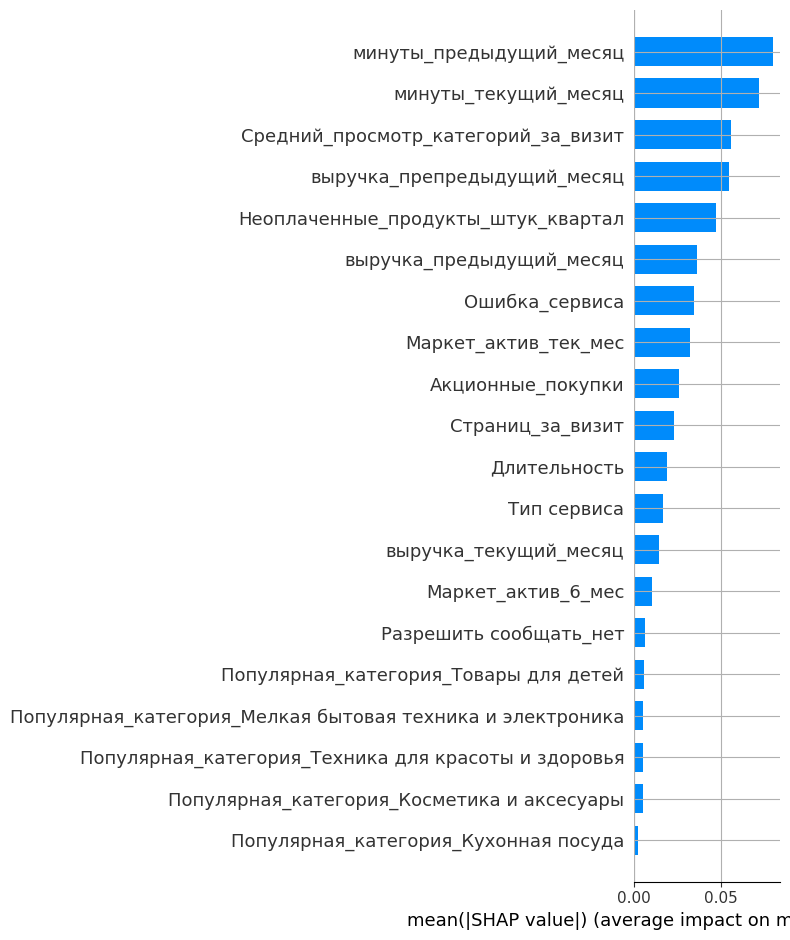

In [427]:
shap.summary_plot(shap_values[:, :, 1], X_test_2, plot_type="bar",
                  feature_names=features_out)

### Выводы о значимости признаков

Больше всего на модель влияет признак содержащий количество страниц, которые пользователь посещает за визит и количество минут, которые пользователь проводил на сайте в предыдущий месяц. Далее идут акционные покупки, средний просмотр категорий за визит, минуты за текущий месяц и выручка за предыдущий месяц.

Меньше всего на модель влияют категории товара и количество маркетинговых коммуникаций в текущем месяце.

Признаки которые меньше всего влияют - следует исключить из модели. А на признаки которые больше всего влияют следует обратить особое внимание. Можно сделать вывод, что посещаемость сайта и длительность посещения сильнее всего влияют на активность пользователей. Следовательно от этого можно отталкиваться при принятии решений

## Шаг 8. Сегментация покупателей

Присоединим данные о прибыли

In [428]:
df_segment = pd.merge(df, money)
df_segment[['id', 'Прибыль']]

,id,Прибыль
0,215349,4.16
1,215350,3.13
2,215351,4.87
3,215352,4.21
4,215353,3.95
...,...,...
1292,216643,4.44
1293,216644,6.11
1294,216645,3.29
1295,216646,4.03


In [429]:
df_segment['выручка_текущий_месяц'] = df_project['выручка_текущий_месяц']

In [430]:
df_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   int64  
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

In [431]:
probabilities = best_model.predict_proba(df_segment)[:, 1]

In [432]:
df_segment['вероятность_снижения_активности'] = probabilities

In [433]:
df_segment.sample(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,Прибыль,вероятность_снижения_активности
1253,216604,Прежний уровень,стандарт,да,4,5,350,0.99,Домашний текстиль,3,4,5,5,14,14,4545.0,4735.0,4840.1,2.88,0.50
543,215894,Снизилась,стандарт,да,3,4,785,0.30,Мелкая бытовая техника и электроника,2,1,3,11,18,22,6149.0,5236.0,5487.3,5.64,0.50
969,216320,Прежний уровень,стандарт,да,4,5,951,0.30,Кухонная посуда,1,4,5,11,12,17,5018.0,4727.0,5400.2,3.73,0.25
963,216314,Прежний уровень,премиум,да,5,5,269,0.21,Товары для детей,2,4,1,17,10,8,5324.0,5493.0,5600.9,4.62,0.00
59,215410,Снизилась,стандарт,да,3,3,1048,0.89,Товары для детей,4,5,3,1,6,4,4839.0,4248.0,4607.6,4.46,1.00


Для выделения группы клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью, нам необходимо определить порог, который будет сообщать о высокой вероятности и высокой прибыльности

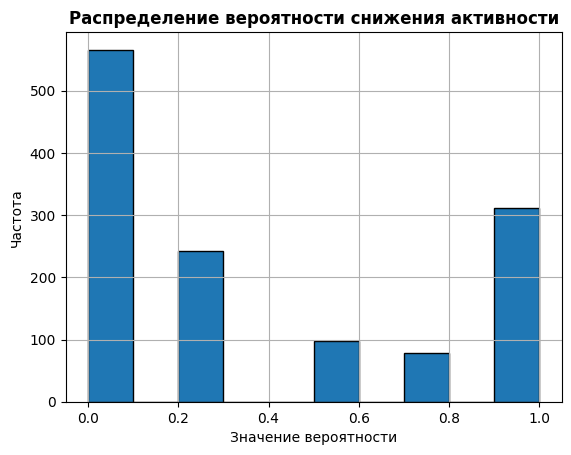

In [434]:
plt.hist(df_segment['вероятность_снижения_активности'], bins=10, edgecolor='black')

plt.title("Распределение вероятности снижения активности")
plt.xlabel("Значение вероятности")
plt.ylabel("Частота")

plt.show()

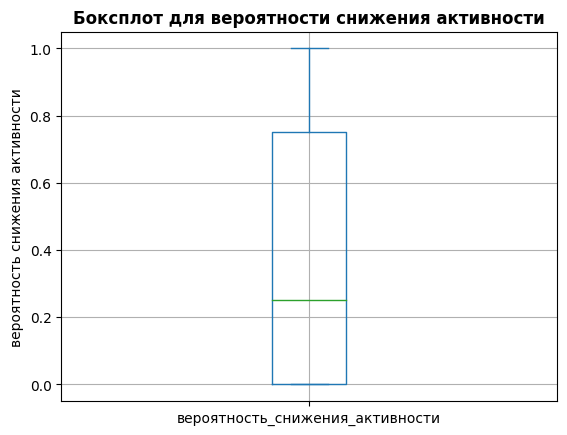

In [435]:
df_segment['вероятность_снижения_активности'].plot(kind='box')
plt.title('Боксплот для вероятности снижения активности')
plt.ylabel('вероятность снижения активности')
plt.show()

In [436]:
percentile = df_segment['вероятность_снижения_активности'].quantile(0.75)
percentile

0.75

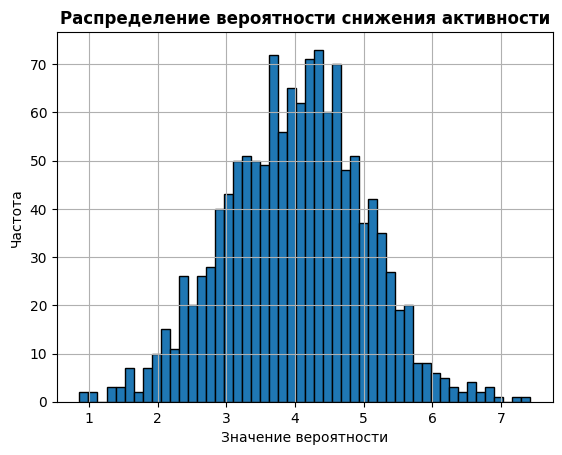

In [437]:
plt.hist(df_segment['Прибыль'], bins=50, edgecolor='black')

plt.title("Распределение вероятности снижения активности")
plt.xlabel("Значение вероятности")
plt.ylabel("Частота")

plt.show()

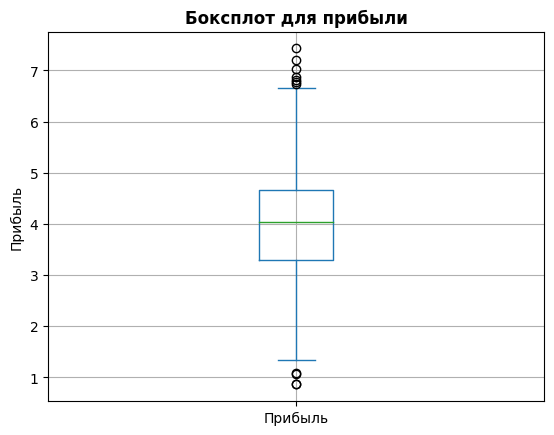

In [438]:
df_segment['Прибыль'].plot(kind='box')
plt.title('Боксплот для прибыли')
plt.ylabel('Прибыль')
plt.show()

In [439]:
df_segment['Прибыль'].mean()

3.9976098689282957

In [440]:
percentile = df_segment['Прибыль'].quantile(0.75)
percentile

4.67

Примем решение о том, что высоким показателем прибыли будут считаться значения выше 3 квартиля, а вероятность_снижения_активности выше 0.5

In [441]:
df_high_income = df_segment[(df_segment['вероятность_снижения_активности'] >= 0.5) & (df_segment['Прибыль'] >= 4.67)]

In [442]:
df_high_income.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 2 to 1256
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   117 non-null    int64  
 1   Покупательская активность            117 non-null    object 
 2   Тип сервиса                          117 non-null    object 
 3   Разрешить сообщать                   117 non-null    object 
 4   Маркет_актив_6_мес                   117 non-null    int64  
 5   Маркет_актив_тек_мес                 117 non-null    int64  
 6   Длительность                         117 non-null    int64  
 7   Акционные_покупки                    117 non-null    float64
 8   Популярная_категория                 117 non-null    object 
 9   Средний_просмотр_категорий_за_визит  117 non-null    int64  
 10  Неоплаченные_продукты_штук_квартал   117 non-null    int64  
 11  Ошибка_сервиса                      

В сегменте получилось 100 пользователей, их прибыль больше чем у 75%  и высокая вероятность ухода согласно предсказанию модели.

In [443]:
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['axes.grid.axis'] = 'both'
plt.rcParams['axes.titleweight'] = 'bold'

In [444]:
def plot_histograms_for_segmen(dataframe1, dataframe2, num_columns):
    num_plots = len(num_columns)
    rows = (num_plots + 1) // 2

    fig = make_subplots(rows=rows, cols=2, subplot_titles=num_columns)

    for i, column in enumerate(num_columns):
        row = (i // 2) + 1
        col = (i % 2) + 1

        fig.add_trace(go.Histogram(x=dataframe1[column], nbinsx=20, name='df_segment', histnorm='probability', marker_color='green'), row=row, col=col)
        fig.add_trace(go.Histogram(x=dataframe2[column], nbinsx=20, name='df_high_income', histnorm='probability', marker_color='orange'), row=row, col=col)

        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray', row=row, col=col)
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray', row=row, col=col)

        fig.update_xaxes(title_text=column, row=row, col=col)
        fig.update_yaxes(title_text='Вероятность', row=row, col=col)

    fig.update_layout(showlegend=True, height=400*rows, width=900, title_text="Гистограммы")
    fig.show()

In [445]:
col_list = ['Страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'выручка_текущий_месяц',
            'выручка_препредыдущий_месяц', 'Средний_просмотр_категорий_за_визит', 'Акционные_покупки',
            'Длительность', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес']

plot_histograms_for_segmen(df_segment, df_high_income, col_list)

In [446]:
df_high_income

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,Прибыль,вероятность_снижения_активности
2,215351,Снизилась,стандарт,да,3,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4,4.87,1.00
7,215356,Снизилась,стандарт,да,4,4,192,0.14,Косметика и аксесуары,2,2,1,3,6,7,4146.5,4433.0,4566.4,4.93,1.00
17,215368,Снизилась,премиум,да,3,5,829,0.24,Техника для красоты и здоровья,2,2,6,1,11,9,5823.0,4536.0,5591.6,6.27,1.00
33,215384,Снизилась,стандарт,да,4,4,1020,0.34,Косметика и аксесуары,2,3,8,3,11,12,3584.0,4226.0,4010.4,4.78,0.50
34,215385,Снизилась,стандарт,да,3,4,721,0.24,Домашний текстиль,5,3,4,4,10,8,6184.5,4707.0,6627.8,4.85,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,216558,Прежний уровень,премиум,да,4,4,684,0.18,Техника для красоты и здоровья,1,6,1,8,15,16,4757.0,4457.0,5147.0,4.85,0.50
1213,216564,Прежний уровень,стандарт,да,5,4,342,0.94,Кухонная посуда,2,7,5,8,14,19,4930.0,5269.0,4766.2,5.58,0.75
1232,216583,Прежний уровень,премиум,да,3,3,280,0.30,Товары для детей,3,4,8,13,17,14,4443.0,4421.0,4553.5,5.42,0.50
1252,216603,Прежний уровень,стандарт,да,4,5,798,0.14,Товары для детей,3,2,6,10,14,17,4004.0,4634.0,3588.0,5.28,0.50


In [447]:
print(df_high_income['выручка_текущий_месяц'].mean())
print(df_segment['выручка_текущий_месяц'].mean())

5222.26923076923
5238.051233616036


In [448]:
print(df_high_income['выручка_предыдущий_месяц'].mean())
print(df_segment['выручка_предыдущий_месяц'].mean())

4916.380341880342
4948.339629915189


In [449]:
print(df_high_income['выручка_препредыдущий_месяц'].mean())
print(df_segment['выручка_препредыдущий_месяц'].mean())

4660.931623931624
4836.367771781033


In [450]:
cat_columns_1 = ['Тип сервиса', 'Разрешить сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес',\
               'Популярная_категория', ]

In [451]:
def plot_pie_charts(dataframe1, dataframe2, columns):
    subplot_titles = ['df_segment', 'df_high_income']

    for column in columns:
        fig = go.Figure()

        labels1 = dataframe1[column].value_counts().index
        sizes1 = dataframe1[column].value_counts().values

        fig.add_trace(go.Pie(labels=labels1, values=sizes1, title=subplot_titles[0],
                             textinfo='percent+label', hole=0.3,
                             marker=dict(colors=['#ff9999', '#66b3ff', '#99ff99'])))
        fig.update_layout(
            title=f"Pie Chart for {column} in {subplot_titles[0]}",
            autosize=False,
            width=800,
            height=500
        )
        fig.show()

        fig2 = go.Figure()
        labels2 = dataframe2[column].value_counts().index
        sizes2 = dataframe2[column].value_counts().values

        fig2.add_trace(go.Pie(labels=labels2, values=sizes2, title=subplot_titles[1],
                              textinfo='percent+label', hole=0.3,
                              marker=dict(colors=['#ff9999', '#66b3ff', '#99ff99'])))
        fig2.update_layout(
            title=f"Pie Chart for {column} in {subplot_titles[1]}",
            autosize=False,
            width=800,
            height=500
        )
        fig2.show()

In [452]:
plot_pie_charts(df_segment, df_high_income, cat_columns_1)

### Вывод по выбранному сегменту:

- У данной категории преобладают покупатели категории товары для детей и косметика и аксессуары, 31% и 27% соответственно. В то время как у всех данных на данные категории приходятся 25% и 19%.

- На 6% больше пользователей приносящих высокую прибыль пользуются тарифом 'премиум'.

- Пользователи данного сегмента чаще всего просматривают две категории.

- Они в среднем проводят около 10 минут на сайте, что меньше чем в среднем все пользователи, а также не просматривают больше 5 страниц за визит. Возможно их не устраивает сайт.

- Средняя выручка в свою очередь тоже меньше, чем в среднем. Однако она увеличивается к текущему месяцу, что хороший знак.


# Общие рекомендации



Цель проекта: разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность, построить модель и, используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения

Все данные соответствовали описанию, пропусков и дубликатов нет ни в каком датафрейме.

Исследовательский анализ данных:


- 'Маркет_актив_6_мес'. Зачастую на покупателя приходится примерно 4 маркетинговых активности за 6 месяцев. Всего может быть от 0 до 6.

- 'Маркет_актив_тек_мес'. Чаще всего за месяц на покупателя приходится 4 маркетинговых активности. Реже - 3 или 5. Интересно, что среднее значение такое же, как и за 6 месяцев.

- 'Длительность' - в среднем у пользователей прошло примерно 600 дней с момента регистрации, что равняется 20 месяцам. В целом значение варьируется от 110 до 1000 и распределено довольно равномерно.

- 'Акционные_покупки' - большинство пользователей не совершали покупки по акции.

- 'Средний_просмотр_категорий_за_визит' - чаще всего просматривают 3 категории за визит.

- 'Неоплаченные_продукты_штук_квартал' - обычно покупатели не оплачивают 3 добавленых в корзину товара за 3 месяца.

- 'Ошибка_сервиса' - на сервисе довольно часто происходят сбои - на одного пользователя приходится от 0 до 9 сбоев. Среднее значение - 4 сбоя.

- 'Страниц_за_визит' - чаще всего за один визит покупатель открывает 8 страниц.

Всего магазин продает 6 категорий товара:

- 'Техника для красоты и здоровья',
- 'Кухонная посуда',
- 'Косметика и аксесуары',
- 'Мелкая бытовая техника и электроника',
- 'Домашний текстиль',
- 'Товары для детей'


Они представлены примерно равномерно, однако больше всего представлена категория товаров для детей и домашнего текстиля. Меньше всего приходится на кухонную посуду.

Рассматривая пользователей, можно отметить, что активность 60% процентов находиться на прежнем уровне, более 70% пользователей пользуется стандартным уровнем сервиса и согласны на получение дополнительных предложений о товаре.

В нашем целевом признаке наблюдается дисбаланс, поэтому будем использовать метрику roc_auc

В таблице market_money было обнаружено одно аномальное значение выручки, которое мы удалили. Помимо этого, мы обнаружили значения равные нулю. Так как нам надо было отберать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период, то мы удалили клиентов с нулевыми значениями.

Следующим шагом мы создали столбцы для каждого из периодов и объединили все в одну таблицу. В ходе дальнейшего корреляционного анализа сильная корреляция наблюдалась у id и покупательской активности. id мы удалили, так как в любом случае не будем использовать этот столбец при обучении. В остальном все признаки коррелируют в пределах нормы.

Для обучения моделей мы использовали паплайны. Лучшей моделью оказалась KNeighborsClassifier(n_neighbors=8) с метрика на тренировочной выборке: 0.89713362227774. ЕЕ метрика ROC-AUC на тестовой выборке: 0.91

Исходя из анализа важности факторов, больше всего на модель влияет признак содержащий количество страниц, которые пользователь посещает за визит и количество минут, которые пользователь проводил на сайте в предыдущий месяц. Далее идут акционные покупки, средний просмотр категорий за визит, минуты за текущий месяц и выручка за предыдущий месяц.

Меньше всего на модель влияют категории товара и количество маркетинговых коммуникаций в текущем месяце.

Признаки которые меньше всего влияют - следует исключить из модели. А на признаки которые больше всего влияют следует обратить особое внимание.

Рассматриваем сегментом мы выбрали покупателей которые приносят высокую прибыль и имеют высокую вероятность снижения активности. Были рассмотрены пользователи этой категории в разрезе пользовательской активности, были сделаты следующие выводы:

- У данной категории преобладают покупатели категории товары для детей и косметика и аксессуары, 31% и 27% соответственно. В то время как у всех данных на данные категории приходятся 25% и 19%.

- На 6% больше пользователей приносящих высокую прибыль пользуются тарифом 'премиум'.

- Пользователи данного сегмента чаще всего просматривают две категории.

- Они в среднем проводят около 10 минут на сайте, что меньше чем в среднем все пользователи, а также не просматривают больше 5 страниц за визит. Возможно их не устраивает сайт.

- Средняя выручка в свою очередь тоже меньше, чем в среднем. Однако она увеличивается к текущему месяцу, что хороший знак.


Можно предложить следующие рекомендации:

- Используйте данные о времени пребывания на сайте и количестве просмотренных страниц для определения областей, где пользователи проводят больше времени и где возможно улучшить пользовательский опыт. Это может включать улучшение навигации, добавление интерактивных элементов или упрощение процесса покупки

- Используйте данные о просмотрах категорий и предыдущих покупках, чтобы предлагать персонализированные рекомендации покупателям. Например, можно показывать рекомендации на основе их предыдущих покупок или просматриваемых категорий.

- Учитывая, что покупатели со сниженным уровнем активности покупают больше товаров по акции, можно предложить им специальные маркетинговые акции и скидки, чтобы стимулировать их покупательскую активность. Например, можно создать ограниченное предложение по времени или предложить бесплатную доставку для определенного объема покупки, или нативную рекламу на основе прошлых покупок.

- Рассмотрите внедрение программы лояльности или бонусной системы, чтобы поощрять покупателей повторно возвращаться и делать покупки. Это может включать сбор бонусных баллов, предоставление эксклюзивных предложений и привилегий для участников программы лояльности

https://github.com/CatSquarel/first_project - ссылка на репозиторий